In [1]:
import sql_helper
import pandas as pd
from pathlib import Path

In [146]:
hospital_csv_path= Path("..") / "data" / "hospital_readmission.csv"
if hospital_csv_path.is_file():
    hospital=pd.read_csv(hospital_csv_path)
    print('hi')
else:
    print("yo")
    conn = sql_helper.connect_server()
    hospital = sql_helper.query_to_table(f"SELECT * FROM work_rizvanov_a263.stroke_cohort_with_readmission_counts;", conn)
    hospital.to_csv(hospital_csv_path)
    conn.close()
hospital=hospital.drop("Unnamed: 0", axis=1)
hospital = hospital[hospital["has_dementia"] == 0]

hi


In [ ]:
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import roc_auc_score, f1_score, classification_report

df = hospital.copy()

feature_cols = [
    'has_aphasia','has_anxiety','has_bipolar','has_depression','has_psychosis','has_ptsd',
    'has_schizo','has_seizure','took_antidep','took_anxiolytic','took_hyp_sed','took_antipsych',
    'antidepressant_pim','anxiolytic_pim','sedative_pim','antipsychotic_pim','any_pim',
    'has_polypharmacy','polypharmacy_count'
]

# --- Final input matrix ---
X = df[feature_cols].fillna(0)
y = (df["readmission_180d"] > 0).astype(int)

# --- Train/test split ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

# --- Base model ---
base = XGBClassifier(
    eval_metric="auc",
    use_label_encoder=False
    scale_pos_weight=y_train.value_counts()[0] / y_train.value_counts()[1]
)

# --- Hyperparameter search space ---
param_dist = {
    "n_estimators": [200, 300, 500, 800],
    "learning_rate": [0.01, 0.03, 0.05, 0.1],
    "max_depth": [2, 3, 4, 5, 6],
    "subsample": [0.6, 0.7, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.7, 0.8, 1.0],
    "min_child_weight": [1, 3, 5, 10],
    "gamma": [0, 0.1, 0.2, 0.3],
    "reg_lambda": [1.0, 1.5, 2.0, 3.0],
    "reg_alpha": [0, 0.1, 0.5, 1.0]
}

# --- Randomized Search ---
search = RandomizedSearchCV(
    estimator=base,
    param_distributions=param_dist,
    n_iter=10,                 
    scoring="f1",
    cv=3,
    verbose=2,
    n_jobs=-1,
    random_state=42
)

search.fit(X_train, y_train)

print("Best params:", search.best_params_)

# --- Train final model using best params ---
best_model = search.best_estimator_

pred_prob = best_model.predict_proba(X_test)[:, 1]
pred_label = best_model.predict(X_test)

print("ROC-AUC:", roc_auc_score(y_test, pred_prob))
print("F1:", f1_score(y_test, pred_label))
print(classification_report(y_test, pred_label))


Fitting 3 folds for each of 10 candidates, totalling 30 fits


d:\Users\rizvanov.a\AppData\Local\miniconda3\Lib\site-packages\xgboost\training.py:199: UserWarning: [18:07:29] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best params: {'subsample': 0.7, 'scale_pos_weight': np.float64(14.263489838822705), 'reg_lambda': 3.0, 'reg_alpha': 0.1, 'n_estimators': 200, 'min_child_weight': 5, 'max_depth': 5, 'learning_rate': 0.05, 'gamma': 0.1, 'colsample_bytree': 0.6}
ROC-AUC: 0.9807838905643318
F1: 0.5891089108910891
              precision    recall  f1-score   support

           0       1.00      0.95      0.97     13570
           1       0.42      1.00      0.59       476

    accuracy                           0.95     14046
   macro avg       0.71      0.98      0.78     14046
weighted avg       0.98      0.95      0.96     14046



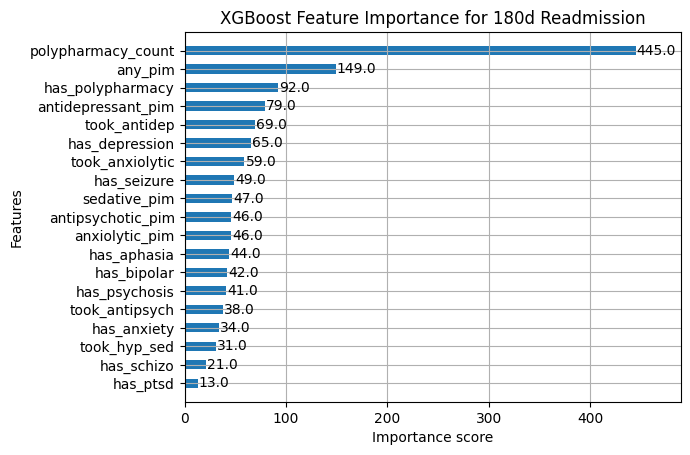

In [ ]:
# ---------------------------------------------------------
# 6. Feature importance
# ---------------------------------------------------------
import matplotlib.pyplot as plt
import xgboost as xgb

xgb.plot_importance(best_model, max_num_features=20, height=0.5)
plt.title("XGBoost Feature Importance for 180d Readmission")
plt.show()


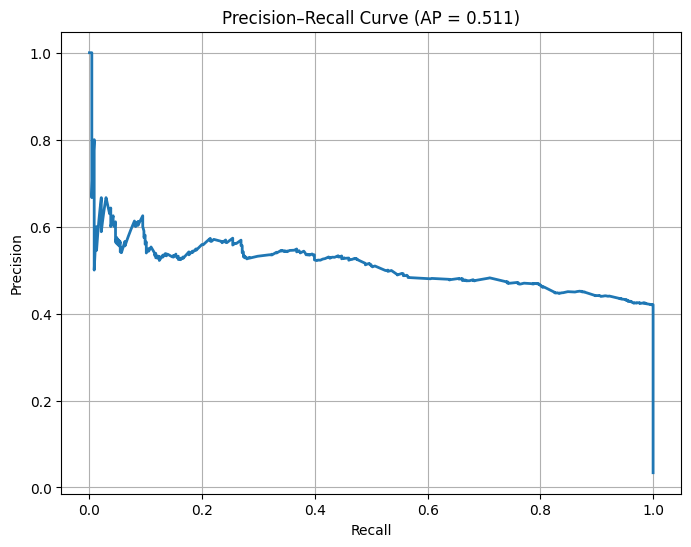

In [163]:
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

# Compute precision–recall curve
precision, recall, thresholds = precision_recall_curve(y_test, pred_prob)

# Compute area under PR curve
ap = average_precision_score(y_test, pred_prob)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, linewidth=2)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title(f"Precision–Recall Curve (AP = {ap:.3f})")
plt.grid(True)
plt.show()


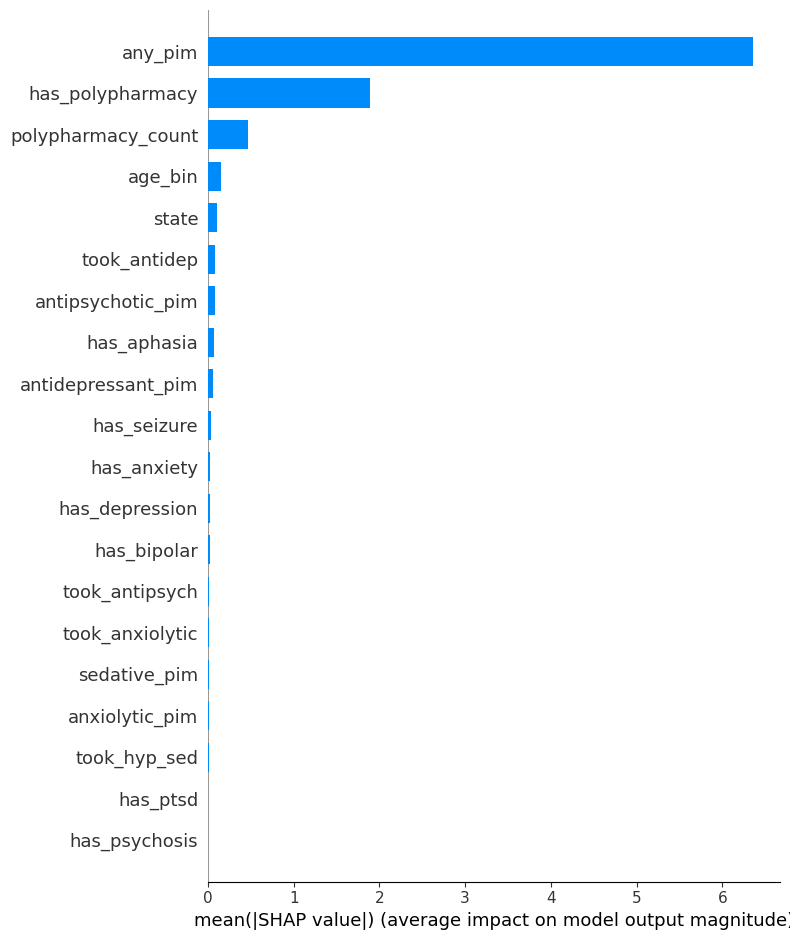

In [138]:
# ! pip install shap
import shap
import matplotlib.pyplot as plt


explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)
explainer.expected_value # base value (expected output)
shap.summary_plot(shap_values, X_test, plot_type="bar")


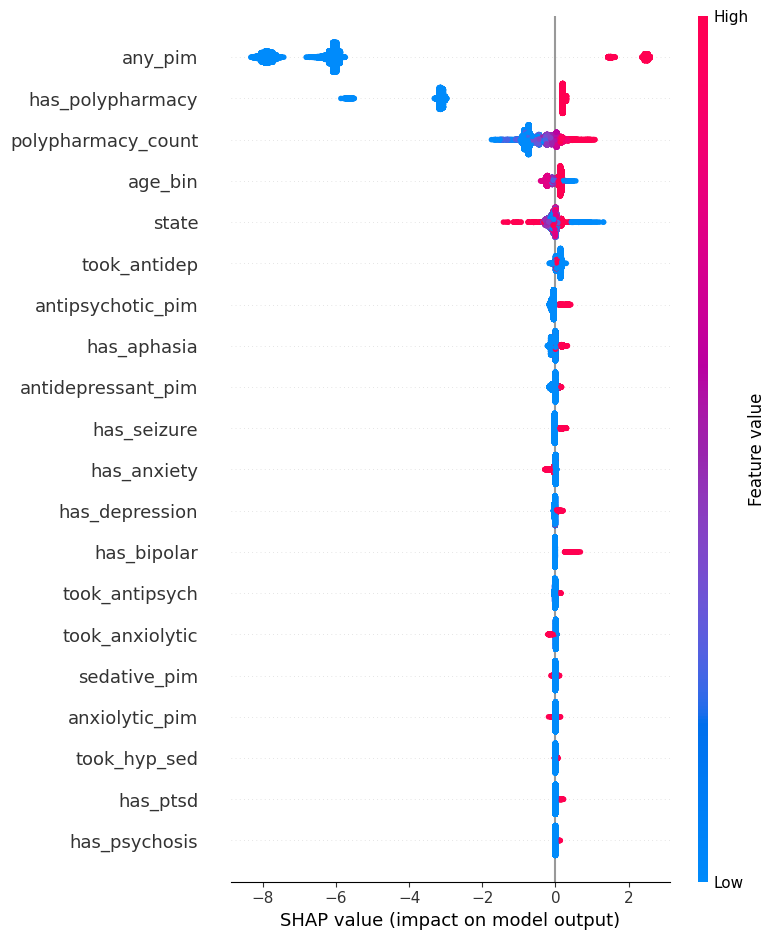

In [139]:
shap.summary_plot(shap_values, X_test)

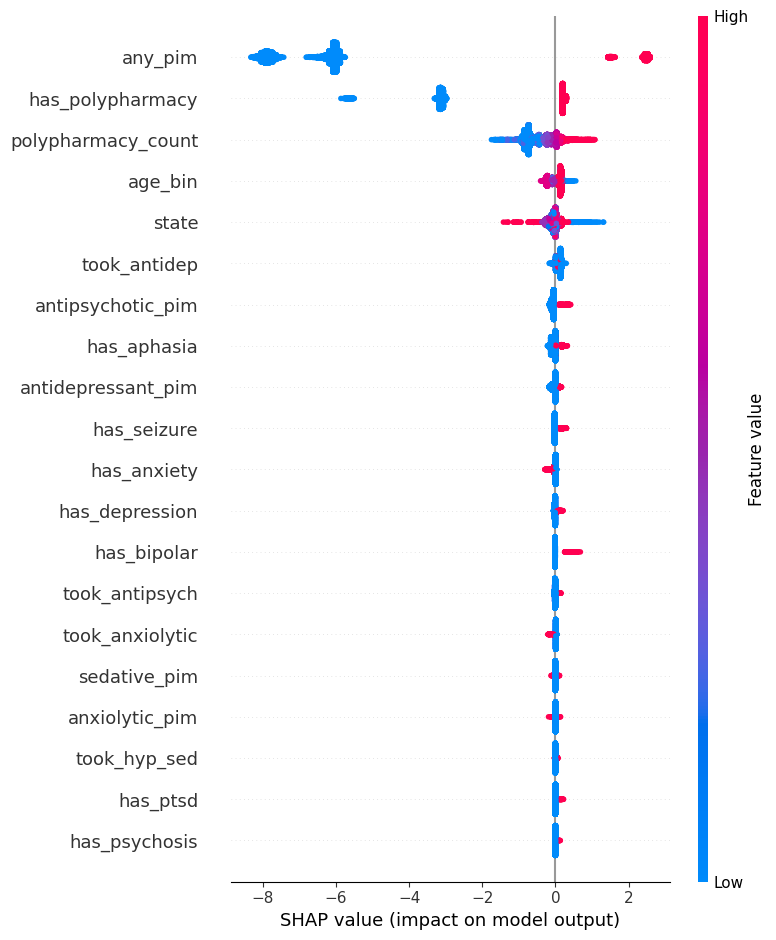

In [140]:
shap.summary_plot(shap_values, X_test)


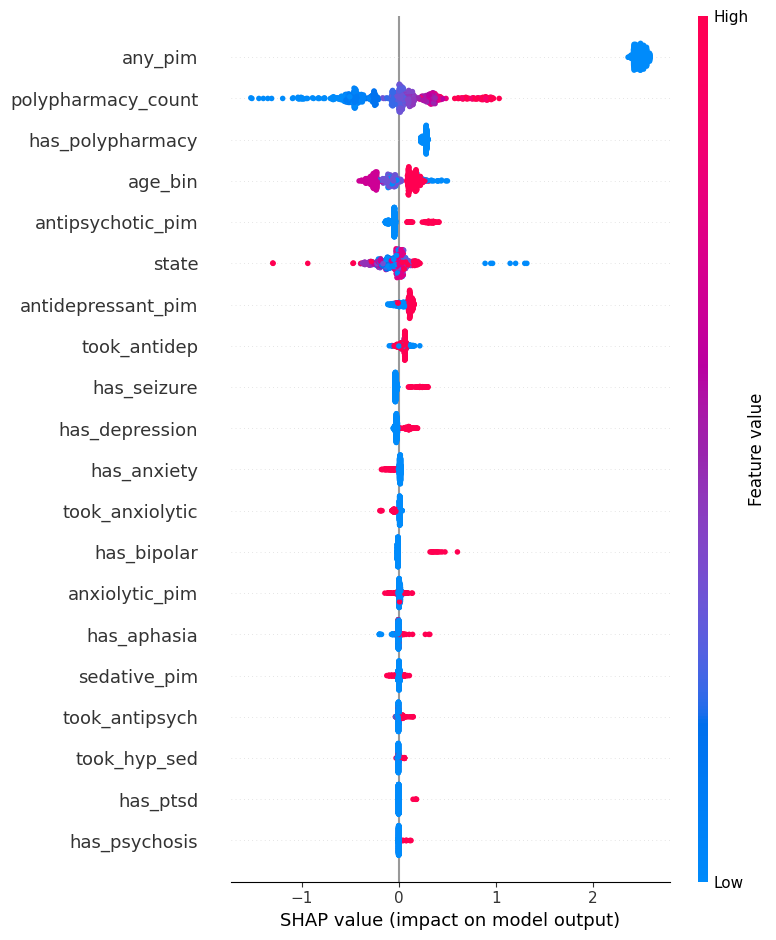

In [141]:
false_pos = (y_test == 0) & (model.predict(X_test) == 1)
shap_values_fp = shap_values[false_pos]

shap.summary_plot(shap_values_fp, X_test[false_pos])